<a href="https://colab.research.google.com/github/ConradBitt/processamento_linguagem_natural/blob/master/Word2Vec_Interpreta%C3%A7%C3%A3o_da_linguagem_com_word_embedding_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução 

O objetivo deste notebook é aprender as chamadas word embedding que são basicamente transformações de textos em vetores, forma que será utilizada para a transformação é conhecida como *one-hot-encoding* que transforma em matrizes esparças de ordem $n$

Além disso, será abordado alguns assuntos sobre o Word2vec que é uma forma de representar uma palavra através de um vetor denso também de tamanho fixo, a vantagem de dessa representação é que muitos modelos conseguem entender o contexto da palavra, por exemplo as palavras *Brasil, China, Peugeot, Ferrari, Bulgaria*, podem ser classificadas em países e carros.

A diferença do one-hot-encoding é que as palavras são vetores independentes e não tem conexão entre elas, já em word2vec as palavras são expressas em vetores que pertencem a um espaço vetorial capaz de clusterizar grupos de palavras de um mesmo contexto.

O Word2vec é extremamente poderozo, pois funciona de duas formas. A primeira é dado um contexto, por exemplo: 

> **Morar no país ____** 

ele consegue estimar soluções para  possível frase. Matematicamente a modelagem é:

$$\vec{v} = (\text{morar, no, país})$$

$$T(\vec{v}) = \text{europeu}.$$

Existe outra forma de utilizar o Word2Vec, que é, através da palavra tentar estimar o contexto, por exemplo:

> **____ __ ____ europeu**

basicamente será encontrar a transformação $T$ inversa, essa técnica é chamada de skipgram ou *proximo grama*.


## Montando Drive

O motivo de usar o colaboratory é porque processamento de linguagem envolve muita memoria RAM e portanto rodar localmente pode se tonar um tanto custoso.Além disso, através do calab é permitido montar uma imagem do drive onde podemos armazenar os dados. Por esses dois motivos optei pelo google colab:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importações

In [2]:
import pandas as pd 
import seaborn as sns 
import numpy as np

from matplotlib import pyplot as plt

sns.set_context('talk')

!unzip '/content/drive/MyDrive/Colab Notebooks/word2vec/dados/cbow_s300.zip'


Archive:  /content/drive/MyDrive/Colab Notebooks/word2vec/dados/cbow_s300.zip
  inflating: cbow_s300.txt           


# Dados 

Os dados são basicamente artigos de jornais

In [3]:
treino = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/word2vec/dados/treino.csv')
teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/word2vec/dados/teste.csv')

In [4]:
display(treino.info())
display(teste.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        90000 non-null  object
 1   text         90000 non-null  object
 2   date         90000 non-null  object
 3   category     90000 non-null  object
 4   subcategory  17175 non-null  object
 5   link         90000 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20513 entries, 0 to 20512
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20513 non-null  object
 1   text         20513 non-null  object
 2   date         20513 non-null  object
 3   category     20513 non-null  object
 4   subcategory  6794 non-null   object
 5   link         20513 non-null  object
dtypes: object(6)
memory usage: 961.7+ KB


None

Temos: 
* 90000 registros nos dados de treino.
* 20513 registros nos dados de teste.

todos os dados são do tipo object, porvavelmente strings dividos em 6 variaveis, `titulo`, `text`, `date`, `category`, `subcategory`, `link`.

Vamos dar uma olhada na distribuição das categorias e subcategorias: 

In [5]:
print('Categorias:')
treino.category.value_counts()


Categorias:


ilustrada    15000
esporte      15000
mercado      15000
mundo        15000
colunas      15000
cotidiano    15000
Name: category, dtype: int64

Note que as categorias principais estar distribuidas de forma homogênea, isto é, temos 15000 amostras em cada uma. 

In [6]:
print('Sub Categoria:')
treino.subcategory.value_counts()

Sub Categoria:


olimpiada-no-rio     2144
monicabergamo        1874
mercadoaberto         736
josesimao             472
helioschwartsman      455
                     ... 
samyadguirni            1
flavia-lima             1
fabio-victor            1
fabianomaisonnave       1
bela-megale             1
Name: subcategory, Length: 227, dtype: int64

diferente das categorias, as subcategorias não estão igualmente distribuidas, tem assuntos mais citados do que outros, vamos olhar as 20 primeiras em um grafico de barras:

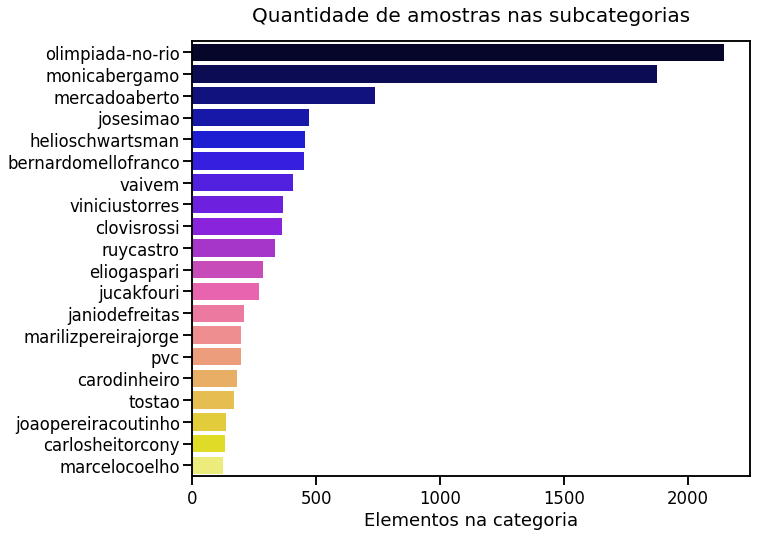

In [7]:
distribuicao_subcategorias = treino.subcategory.value_counts().to_frame()

plt.figure(figsize=(10,8))
plt.title('Quantidade de amostras nas subcategorias', fontsize=20, pad=20)
ax = sns.barplot(data=distribuicao_subcategorias[:20], 
            x='subcategory', 
            y=distribuicao_subcategorias.index[:20], palette='gnuplot2')
ax.set_xlabel('Elementos na categoria')
ax;

## Pre processamento 

Vemos que algumas variááveis são do tipo textual, por exemplo o conteúdo de um artigo e o seu título

In [8]:
display(treino.iloc[645]['title'])
print('\n')
display(treino.iloc[645]['text'])

'Após maior derrota, Anderson Silva volta com outro modelo de preparação'

'Um Anderson Silva diferente do que deixou o octógono com a perna esquerda fraturada há 13 meses retorna ao UFC, nesta madrugada de sábado para domingo, para enfrentar o norte-americano Nick Diaz, em Las Vegas, nos Estados Unidos.  Enquanto veste os apetrechos para a aula de mergulho, Anderson, 39, olha para o lado e sorri para a mulher e dois de seus filhos que se preparam para acompanhá-lo na aula, em Los Angeles.  Esse é um dos relatos do Spider aos colegas de treino sobre como esse pausa permitiu a ele, enfim, passar um tempo com a família para "ver os filhos crescerem".  No começo da carreira, antes de o UFC surgir, Anderson passava a maior parte do tempo fora de casa, dando aulas de artes marciais para manter, com muita dificuldade, sua família. Com a fama, os ganhos aumentaram, mas o convívio com a família, não.  "Até então, o Anderson passava a maior parte do tempo viajando, treinando, lutando. Ou tinha de atender a outros compromissos", conta Rodrigo "Minotauro" Nogueira, amig

dito isso precisamos realizar um pré processamento, isto é, vetorizar estas informações e realizar alguns tratamentos na string em si, como retirar acentos, caracteres especiais, letras maiusculas e minusculas.

# Vetor de palavras

Para perguntas se uma pessoa tem um carro inglês usamos a frase:

> Do you have a car?

E ai aprendemos como fazer uma pergunta em inglês, saimos então perguntando para todas as pessoas possíveis: *Do you have a car? Do you have a car? Do you have a car?*. Ai geralmente as pessoas pegam a "ideia" de como é a estrutura de uma pergunta, e agora como fazemos pra perguntar se uma mulher tem um carro? Bom usamos a frase:

> Does she have a car?

Então perguntamos para todas as pessoas que conhecemos: *Does she have a car? Does she have a car? Does she have a car?*. Note que só mudamos o sujeito da frase, no caso foram duas palavras, e criou-se uma nova frase a partir da *Do you have a car?*.

Agora queremos saber se ela tem uma bicicleta, como faríamos?

> Does she have a bike?

Note que o que mudamos apenas algumas palavras da frase. Ou seja, aprendemos uma estrutura da frase e a partir dela conseguimos várias outras, isso significa que fomos capazes de generalizar a frase.

### Vetorizando uma frase

Vamos supor que temos as seguintes frases:

> TENHA UM BOM DIA

> TENHA UM ÓTIMO DIA

> TENHA UM PÉSSIMO DIA

É comum chamar de *corpus textual* o conjunto de todas as frases que se tem, por exemplo, a variável ``text`` dos dados de treino é o nosso corpus textual.

Para vetorizar uma frase, a primeira coisa que deve ser feita é pegar as palavras do corpus textual sem repetição. Aplicando isso ao nosso corpus teríamos: 

> TENHA UM **BOM ÓTIMO PÉSSIMO** DIA

Quando retiramos palavras repetidas de um corpus criamos um *vocabulário* e a partir do vocabulário contruimos um vetor que auxilie a não confundir as palavras *BOM* com *TENHA* ou com *ÓTIMO*. 

$$\vec{v} = (\text{TENHA, UM, BOM, ÓTIMO, PÉSSIMO, DIA})$$

Aqui podemos tirar uma conclusão: o vetor da palavra terá a mesma dimensão do corpus textual.

Outra forma de expressar uma frase é atraves de uma matriz:

$$
A = \begin{pmatrix} 
  1 & 0 & 0 & 0 & 0 & 0 \\ 
  0 & 1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 1 & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 \\
  \end{pmatrix}
$$

Desse forma **as palavras estão expressas nas colunas**, e portanto são linearmente independentes. Então temos um vetor de ordem $n$ que representa uma palavra de um vocabulário, esta é a técnica chamada de *one-hot-encoding*.


#### Exemplo: 
Vamos vetorizar uma frase, por exemplo: 

> O corretor de imóveis vendeus 5 casas

> A corretora de imóveis vendeus 6 apartamentos

In [9]:
texto = [
    'TENHA UM BOM DIA',
    'TENHA UM ÓTIMO DIA',
    'TENHA UM PÉSSIMO DIA'
]

def vetoriza_frase(frases):
  vocabulario = []
  for frase in frases:
    vetor_frase = frase.split(' ')
    for palavra in vetor_frase:
      if palavra not in vocabulario:
        vocabulario.append(palavra)
  return vocabulario

vocabulario = vetoriza_frase(texto)
print(vocabulario)

['TENHA', 'UM', 'BOM', 'DIA', 'ÓTIMO', 'PÉSSIMO']


Note que o vocabulário poderia esta necessariamente ordenado na ordem que desejamos. Sim, por definição um vetor é uma *$n$-upla ordenada*, entretanto quando juntamos os vetores de palavras em uma matriz, é permitido trocar linhas e colunas de lugar, assim como é permitido trocar palavras em uma frase. Então, um vocabulário é um vetor que pertence à um espaço vetorial cujo os vetores de base são as palavras vetorizadas.

A implementação do código acima funciona para pequenos textos, mas para grandes volumes de dados ela pode ter um desempenho não tão eficiente. Portanto, vamos utilizar um módulo chamado Sci Kit Learning que tem uma função capaz de vetorizar corpus textuais.

O SKLearn tem todo um ferramental de machine learning, em especial o módulo: [sklearn.feature_extraction.text](https://sklearn.org/modules/classes.html#module-sklearn.feature_extraction.text) é voltado exclusivamente para texto. A rotina que vou utilizar deste módulo é a ``CountVectorizer()``

A descrição deste objeto é: 

```python
class sklearn.feature_extraction.text.CountVectorizer(input=’content’, encoding=’utf-8’,
 decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, 
 tokenizer=None, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1),
  analyzer=’word’, max_df=1.0, min_df=1, max_features=None,
   vocabulary=None, binary=False, dtype=<class ‘numpy.int64’>)
```

    Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of
    feature selectionthen the number of features will be equal to the vocabulary size found by analyzing the data.

[Read more in the User Guide](https://sklearn.org/modules/feature_extraction.html#text-feature-extraction).

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

Vamos textar a função com a frase que já propomos: 

In [11]:
texto = [
    'TENHA UM BOM DIA',
    'TENHA UM ÓTIMO DIA',
    'TENHA UM PÉSSIMO DIA'
]

# criando um vetorizador 
vetorizador = CountVectorizer()

# ajustando o vetorizador ao texto
vetorizador.fit(texto)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [12]:
print(vetorizador.vocabulary_)


{'tenha': 3, 'um': 4, 'bom': 0, 'dia': 1, 'ótimo': 5, 'péssimo': 2}


note que ele criou um dicionario com todas as palavras que não se repetem. Agora surge a vantagem do SK Learning, como seria o vetor da palavra ``BOM``?

Para isso pegamos o objeto vetorizador:

In [13]:
vetor_bom = vetorizador.transform(['BOM'])
vetor_bom

<1x6 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

O resultado é uma matriz esparsa de ordem 1x6. Podemos transformar esta matriz em um array para visualiza-la

In [14]:
print(vetor_bom.toarray())

[[1 0 0 0 0 0]]


A palavra ``BOM`` é expressa pelo vetor $(1,0,0, 0, 0, 0)$. Podemos saber qual o elemento não nulo do vetor apenas olhando os valores do vocabulario:

In [15]:
print(vetorizador.vocabulary_)

{'tenha': 3, 'um': 4, 'bom': 0, 'dia': 1, 'ótimo': 5, 'péssimo': 2}


Se quisermos formar as frases:

> BOM DIA: $$(1,0,0,0,0,0) + (0,1,0,0,0,0) = (1,1,0,0,0,0)$$

> PÉSSIMO DIA: $$(0,0,1,0,0,0) + (0,1,0,0,0,0) = (0,1,1,0,0,0)$$

Note que as frases são diferentes porquê os vetores são diferente... 

A dimenssionalidade da frase implica diretamente na dimenssionalidade do vocabulario, pois a dimenssionalidade do vocabulário é no minimo igual ou menor que a da frases e isso pode ser um problema computacionalmente.

> Um simples tweets de 240 caracteres pode gerar um vetor de ordem $(1,240)$.

Ai surge uma outra forma de tentar expressar frases através de vetores, visando evitar esse problema de matrizes e vetores esparsos. 



## Word2vec 

Suponha que temos as palavras:

> Itália, Rússia, Ferrari, China, Peugeot, França

e precisamos organiza-las. Como isso pode ser feito? Poderiamos tentar organizar em dois grupos *carros* e *países* e tentar dispor em um plano cartesiano, onde o eixo X indica se é um carro ou não, e o eixo Y se é um paíse ou não. É basicamente isso o que é feito em uma tecnica de one-hot-encoding, dispor cada variável em um vetor independente. Mas e se primeiro colocassemos os dados e depois ajustamos o plano?

Eu faria desta forma, colocaria os dados das marcas de carro na parte superior direita e os paises na inferior esquerda:

<img src='https://raw.githubusercontent.com/ConradBitt/processamento_linguagem_natural/master/images/clusters.png' width=80%>

Além disso, note que os paises asiáticos estão mais próximos da origem do plano e os paises europeus em um pouco distante. O mesmo acontece com os veículos, a marca itaiana esta acima da francesa, seguindo o padrão do grupo anterior.

Desta forma conseguimos representar informações em um plano carteziano, apesar de varias informações diferentes, este problema tem apenas **dois graus de liberdade $(x,y)$**, esse é o conceito fundamental do word2vec.

Vamos supor que temos a seguinte frase:

> **Eu moro na _____, um país lindo**

As possíeis soluções são: *Rússia, China, Italia, França ou qualquer outro país*. Mas como sabemos disso? Bom, sabemos das possíveis soluções porque durante anos, estudamos geografia, assistimos filmes, consumimos livros, e várias outras fontes de informações que possibilitam estimar que a possivel solução é um país

Outra frase seria:

> **Eu dirijo um(a) _____ azul**

As possíveis soluções são *Ferrari, Peugeot, Jeep, Ford ou quaqluer automóvel* e a forma de solucionar é a mesma, sabemos o contexto da pergunta e por isso estimamos possíveis soluções. A grande questão é: **Como ensiar o contexto pra uma máquina?**

# Como ensinar contexto?

Assim como uma criança um computador não sabe o que é contexto. A crianças aprendem muito mais repetindo ações dos adultos do que por si só e para ensinar contexto para a maquina precisamos mostrar o que é um contexto e isso é feito através de dados.

> Não são um, nem duas amostras. Para ensinar um contexto é necessário dezenas de milhares de amostras, assim como acontece com crianças apesar de nem percebemos que fornecemos este tanto de informação à elas.

Já que conseguimos transformar frases em vetores densos podemos usar todo o aparato da álgebra vetorial para resolver esse problema. Note que no problema de estimar uma solução de:

 >**moro _____ país**

 As possíveis soluções são varios paises, note que pra um mesmo vetor de contextos existem varios outros vetores que solucionam o problema. 
 
> Esta tecnica de tentar estimar uma palavra através de um contexto se chama **CBOW** (*Continous Bag Of Words*). Outra tecnica se chama **Skip Gram** e consiste em estimar o contexto através da palavra.

O artigo desses modelos foi escrito por Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean, do Google, sob o título de [Efficient Estimation of Word Representations inVector Space](https://arxiv.org/pdf/1301.3781.pdf). A principal diferença entre CBOW e SkipGram é que, através do SkipGram o volume de dados é menor e este algorítmo é capaz de gerar vetores que contextualizam melhor a frase, em contra partida o CBOW tem um processo de treinamento mais rápido.

# Resumo de como funciona o Word2vec

Como já foi motrado anteriormente o word2vec é diferente do one-hot-encoding por conseguir representar uma frase através de um vetor num espaço vetorial de dimensão fixa, por exemplo, ordem $10, 100, 200, 300,$ etc.

Não vamos treinar necessariamente uma rede word2vec, vamos utilizar um modelo treinado do NILC ([núcleo institucional de linguistica computacional](http://www.nilc.icmc.usp.br/nilc/index.php)), laboratório da USP. O NILC tem um repositório só para word embeddings 

> http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

Apesar de já ser um modelo pré treinado ainda sim é necessario um volume bem grande de dados. O NILC já fornece vetores de palavras pre treinados, o que vou utilizar aqui é ``CBOW_s300``, basicamente um um CBOW com vetores de ordem $300$.

Temos as CBOW's no arquivo ``cbow_s300.txt`` na raiz da maquina virtual do colab. vamos visualizar as 5 primeiras linhas deste arquivo:




In [16]:
with open('cbow_s300.txt') as f: 
  for linha in range(5):
    print(next(f))

929606 300

</s> -0.001667 -0.000158 -0.000026 0.001300 -0.000796 0.001527 0.000046 0.000584 0.000449 -0.000100 0.000353 0.001251 0.001069 0.000506 0.000574 0.000838 -0.000930 -0.001220 0.000317 0.001315 -0.001120 0.001373 -0.000040 -0.001580 0.000421 -0.000667 -0.001556 -0.000746 0.001604 0.001157 -0.000027 0.000354 0.000358 -0.000527 -0.000573 -0.001512 -0.001557 -0.001637 0.001617 -0.001511 -0.001022 -0.001426 0.001086 -0.001033 0.000593 0.000724 0.000627 -0.000450 -0.001140 0.000333 0.000524 0.001541 0.000284 0.000617 -0.000807 -0.000088 -0.000364 0.001126 -0.001230 -0.001138 -0.001280 0.001330 0.001257 0.000576 0.000764 0.000684 0.001008 -0.000215 -0.000629 -0.001228 -0.001557 -0.000311 -0.000246 0.000045 0.001136 -0.000645 -0.000549 0.001099 0.000858 -0.000886 0.000553 0.000303 0.001433 0.000732 0.001321 -0.000894 -0.000700 -0.000661 -0.001484 -0.000950 -0.001556 -0.000809 0.000348 -0.000068 0.000724 -0.000569 -0.000161 -0.001628 -0.001437 -0.000259 -0.000296 -0.001571 0.000149 0

As cinco primeiras linhas do arquivo são expressas em chave-valor, onde a chave é o caracter/palavra e o valor é a sua representação num espaço vetorial de ordem $300$, note que a primeira representação é fakechar ``</s>`` usado pra criar *ngrams*. Esses dados estão em formato texto, precisamos transforma-los em vetores. 

## Modelos do NILC 

### Como Utilizar
Os modelos do NILC estão corrigidos para serem carregados somente utilizando o ``KeyedVectors`` do ``gensim``. Além disso, todas as embeddings estão sendo carregadas como unicode.

Para executar os modelos e utilizar os vetores pré-treinados, siga os passos abaixo.

### Instalar
```python
pip install gensim==2.0.0
```
### Rodar
```python
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(‘model.txt’)
```


In [17]:
import gensim

gensim.__version__

'3.6.0'

vamos usar esta versão mesmo.

In [18]:
from gensim.models import KeyedVectors

### Modelo treinado

<font color='red'><b>Lembrando: Os dados do NILC tem mais de um milhão de amostras, portanto ao executar esta célula pode levar algum tempo.</b></font>

In [19]:
modelo = KeyedVectors.load_word2vec_format('cbow_s300.txt')

Com o modelo treinado podemos analisar o vetor de algumas palavras que ele contem: 

In [20]:
modelo.get_vector('china')

array([-1.49033e-01,  1.26020e-01,  2.17628e-01,  1.82684e-01,
        1.65151e-01, -1.59660e-01, -2.34411e-01,  6.00570e-02,
        8.03680e-02,  2.87578e-01, -4.81100e-03, -5.68800e-02,
        2.15676e-01,  8.65540e-02,  1.25983e-01,  3.36157e-01,
       -1.83254e-01, -1.18499e-01,  1.13010e-02,  1.03814e-01,
        9.37640e-02,  2.90178e-01, -1.64395e-01, -1.13300e-02,
       -1.80676e-01, -1.15820e-02,  1.08728e-01,  1.65898e-01,
        9.37900e-02,  2.66767e-01, -1.29890e-02,  9.16030e-02,
        2.21292e-01, -1.36497e-01, -4.26350e-02, -1.30038e-01,
        2.17067e-01, -1.01963e-01, -3.70960e-02,  1.42155e-01,
        3.41109e-01,  2.46560e-01,  1.27458e-01,  5.72360e-02,
       -1.47962e-01, -1.60290e-02,  1.86533e-01,  7.71550e-02,
       -3.50024e-01, -4.06085e-01,  1.67131e-01, -4.75230e-02,
        5.13780e-02, -1.28224e-01,  1.06580e-02, -2.92652e-01,
        1.40540e-01, -4.57049e-01,  1.31094e-01,  2.03234e-01,
        2.94019e-01,  7.38370e-02,  1.11554e-01, -1.642

podemos ver a ordem deste vetor:


In [21]:
modelo.get_vector('china').shape

(300,)

o vetor tem ordem 300, como já era de se esperar. 

### Contexto

 Dado que conseguimos obter o vetor das palavras, como fazemos para analisar se duas palavras estão proximas? Bom, da geometria analítica podemos calcular a distância entre pontos... Entretanto vetores não fazem muito sentido para nós, então vamos pedir para o modelo retornar os dados mais similares à palavra china:

In [22]:
modelo.most_similar('china')

[('rússia', 0.7320704460144043),
 ('índia', 0.7241617441177368),
 ('tailândia', 0.701935887336731),
 ('indonésia', 0.6860769987106323),
 ('turquia', 0.6741335988044739),
 ('malásia', 0.6665689945220947),
 ('mongólia', 0.6593616008758545),
 ('manchúria', 0.6581847667694092),
 ('urss', 0.6581669449806213),
 ('grã-bretanha', 0.6568098068237305)]

perceba que todos são países! Além disso a ordem em que os países estão são similares à proximidade entre as nações. 

Vamos testar com a itália

In [23]:
modelo.most_similar('itália')

[('frança', 0.7983609437942505),
 ('grécia', 0.7547340989112854),
 ('espanha', 0.7417078018188477),
 ('holanda', 0.7343162298202515),
 ('grã-bretanha', 0.7281740307807922),
 ('inglaterra', 0.7172061204910278),
 ('bélgica', 0.7155542373657227),
 ('alemanha', 0.7135661840438843),
 ('suécia', 0.6831519603729248),
 ('áustria', 0.6822685599327087)]

o resultado é similar, exceto pelo fato em que os países mais próximos são os europeus!

Podemos testar com a palavra peugeot:

In [24]:
modelo.most_similar('peugeot')

[('porsche', 0.6261278390884399),
 ('fiat', 0.6126313209533691),
 ('mazda', 0.550723671913147),
 ('boeing', 0.5501567125320435),
 ('volvo', 0.5446159839630127),
 ('mercedes-benz', 0.5393132567405701),
 ('toyota', 0.5379929542541504),
 ('gtb', 0.5309687852859497),
 ('ferrari', 0.5242953300476074),
 ('honda', 0.5188493728637695)]

Como estamos representando palavras num espaço vetorial, uma das operações que podemos fazer é somar palavras, ou compor duas delas. Por exemplo, quando usamos as palavras ``chile`` e ``argentina`` as palavras mais provaveis que estão neste grupo são espanhol, america, brasil, etc. Vamos verificar quais são as palavras mais próximas dos grupos ``brasil + argentina``

In [25]:
modelo.most_similar(positive=['brasil','argentina'])

[('chile', 0.6781662702560425),
 ('peru', 0.6348033547401428),
 ('venezuela', 0.6273865103721619),
 ('equador', 0.6037014722824097),
 ('bolívia', 0.6017140746116638),
 ('haiti', 0.5993807315826416),
 ('méxico', 0.5962306261062622),
 ('paraguai', 0.5957703590393066),
 ('uruguai', 0.5903672575950623),
 ('japão', 0.5893509984016418)]

### Plural

Um ponto interessante do word2vec é que em tese é possível identificar o plural de algumas palavras, por exemplo, digamos que temos a palavra *NUVEM* o plural é *NUVENS*, ou até mesmo *ESTRELA* o plural é *ESTRELAS*. De certa forma deveria ser possível realizar algumas operações do tipo 

> $\text{NUVENS + ESTRELA - NUVEM = ESTRELAS}$

In [26]:
modelo.most_similar(positive=['nuvens','estrela'], negative=['nuvem'])

[('estrelas', 0.5497429966926575),
 ('plêiades', 0.379197895526886),
 ('colinas', 0.3746805191040039),
 ('trovoadas', 0.373703271150589),
 ('sombras', 0.3734194040298462),
 ('pombas', 0.3726757764816284),
 ('corredoras', 0.3640727698802948),
 ('cigarras', 0.36065393686294556),
 ('galáxias', 0.35754913091659546),
 ('luas', 0.3575345277786255)]

Outra possibilidade é tentar realizar operações com as palavras e tentar descobrir outras, por exemplo, tentar descobrir o feminino de alguma palavra em português, por exemplo:

> $\text{PROFESSOR + MULHER - HOMEM = PROFESSORA}$

In [27]:
modelo.most_similar(positive=['professor','mulher'], negative=['homem'])[0]

('professora', 0.6192208528518677)

Apesar de fazer todo sentido estas operações precisamos ficar muito atentos com algumas coisas que precedem os dados. Vamos tentar adivinhar qual o feminino da palavra "médico", a operação esperada é: 

> $MEDICO + MULHER - HOMEM = MEDICA$

mas o resultado é:

In [28]:
modelo.most_similar(positive=['medico','mulher'], negative=['homem'])[0]

('enfermeira', 0.5567789673805237)

note que **o resultado do modelo não associa a palavra "médica" como pertencente ao mesmo grupo de "médico". Não tem nada de errado com o modelo em si, pois ele acertou quando se tratava da palavra "professora", o problema esta na forma em que os dados foram alimentados.** Tem mais de milhão de palavras que compõem esta base de dados, elas foram retiradas de livros, artigos de jornais, posts na internet e servem de base para o modelo extrair algum padrão de contexto destas palavras. O modelo não cria nada novo, ele só reproduz um padrão que já esta contido nos dados, por exemplo, **achar que o feminino de médico é enfermeira**.

**Aqui vai um ponto extremamente importante, quando utilizamos dados do passado para estimar o futuro devemos tomar muito cuidado, pois alguns eventos do passado não devem ser aceitos. Temos uma obrigação moral de não reproduzir alguns padrões já presentes na sociedade.**


### Alguns pontos sobre etica dem IA 

O fato de se ter modelos extremamente promissores em áreas da interligência artificial foi fundamental para a disponibilidade de alguns serviços. Por outro lado, devemos tomar muito cuidado para não reproduzir preconceitos, problemas estruturais em nossa sociedade e impulsionar ainda mais desigualdade social.

Em 2019, o cientista Richard Socher da Salesforce, no fórum economico internacional apresentou um artigo interessante com o título [*AI isn’t dangerous, but human bias is*](https://www.weforum.org/agenda/2019/01/ai-isn-t-dangerous-but-human-bias-is/) sobre o tema do quão perigoso modelos de IA podem ser para sociedade moderna dado que os dados dos modelos são alimentados com dados reais e isso inclui nossos problemas estruturais.

Outra referência sobre o assunto é abordada no [capítulo 6 seção 6.11 - *Bias and embeddings*](https://web.stanford.edu/~jurafsky/slp3/6.pdf) do livro [*Speech an Language Processing*](https://web.stanford.edu/~jurafsky/slp3/old_oct19/edbook_oct162019.pdf) escrito por Dan Jurafsky e James H. Martin. Nesta seção eles abordam o tema **viés** que vai além de uma mera tendência e trás outras referências para reduzir este problema de embedding de palavras. 

# Vetorizando dados necessarios para classificação

Ateriormente mostrei como funciona brevemente a importação de um conjunto de vetores em word2vec do NILC e ajustar à um modelo já treinado do módulo [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html#documentation). Acontece que nossos dados de treino são textos brutos, veja:

In [29]:
for texto in treino[['title','text']].iloc[-10]:
  display(texto)
  print('\n')

'Pagamento de propina pode chegar a R$ 50 mil por carga'

'A corrupção é um dos principais fatores que contribuem para o alto índice de produtos contrabandeados no país, de acordo com estudo realizado pelo Idesf (Instituto de Desenvolvimento Econômico e Social de Fronteiras), antecipado para a Folha e que está sendo apresentado na manhã desta terça-feira (3).  O pagamento de propina pode chegar a R$ 50 mil, afirma a pesquisa, que mostra que a corrupção para liberação de cargas ilegais ocorre em vários níveis operacionais e é dividida em quatro momentos.  O primeiro momento ocorre próximo à barranca do Rio Paraná e às margens do Lago de Itaipu, em Foz do Iguaçu. Nesse ponto, diz o estudo, o contrabandista paga cerca de R$ 100 ao dia por agente público para que fique indiferente à ilegalidade.  O segundo momento é quando o ente público faz um acordo com o contrabandista para o acompanhamento da carga até o limite da sua jurisdição. Isso evita que a carga seja apreendida nos postos de fiscalização e, para isso, o contrabandista paga entre R$ 1.0

precisamos de alguma forma vetorizar o nosso texto através da tecnica word2vec, e isso será feito através de algumas etapas.

## Tokenização dos dados

O processo de tokenização é simplesmente seprar cada palavra de uma frase, por exemplo

> Tokenizando a frase: "Ola Mundo"

A frase acima tokenizada seria: 

```python
>>frase = 'Tokenizando a: frase "Ola Mundo"'
>>frase.split()
['Tokenizando', 'a:', 'frase', '"Ola', 'Mundo"']
```

O método ``split()`` pode ser útil, entretanto ele não remove aspas, dois pontos e nem caracteres especiais, podemos usar o módulo ``unidecode`` para remover estes caracteres, entretanto existe um módulo chamado [NLTK](https://www.nltk.org/_modules/nltk/stem/wordnet.html) que já tem uma rotina de tokenização implementada. A função se chama [``word_tokenize()``](https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktLanguageVars.word_tokenize) que tokeniza frases retirando pontos e outros caracteres especiais.

Vamos então criar uma função que vai tokenizar as palavras e criar uma representação word2vec para cada palavra:

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [31]:
import string

def tokezinador(texto):

  texto = texto.lower()
  lista_alphanumerica = []

  tokens_do_texto = nltk.tokenize.word_tokenize(texto)

  for token in tokens_do_texto:
    if token in string.punctuation: continue
    lista_alphanumerica.append(token)

  return lista_alphanumerica

Vamos testar a função em um titulo:


In [35]:
print(f'Titulo original: {treino.title.iloc[30]}')
print(f'Titulo tokenizado: {tokezinador(treino.title.iloc[30])}')

Titulo original: Embaixador da 'Emolândia', Morrissey faz show sentimental em SP
Titulo tokenizado: ['embaixador', 'da', "'emolândia", 'morrissey', 'faz', 'show', 'sentimental', 'em', 'sp']


Agora precisamos representar os tokens em um espaço vetorial. Lembrando que a representação em word2vec é fixa, isto é, a palavra depende de um espaço vetorial, no nosso caso a dimensão é de $300$.

Dado que uma frase é composta por palavras pertencentes à um espaço vetorial então ela pode ser expressa como uma combinação linear de varios vetores, então vamos somar todos os vetores dos tokens que compõem a frase para vetoriza-la

In [38]:
def vetorizar_tokens(tokens):
  token_vetorizado = np.zeros(300)

  for token in tokens:
    # soma os vetores de cada token pra construir um vetor da frase.
    token_vetorizado += modelo.get_vector(token)

  return token_vetorizado 


Vamos testar:

In [46]:
print(f'frase: {treino.title.iloc[0]}')

print(f'\nfrase vetorizada: {vetorizar_tokens(tokezinador(treino.title.iloc[0]))}')

frase: Após polêmica, Marine Le Pen diz que abomina negacionistas do Holocausto

frase vetorizada: [ 0.52357099  1.00529201  0.26381801  0.55167001  1.29887401 -0.300037
  0.89378801  0.11975599 -1.45775002 -0.452488    0.458223   -0.21807001
  0.65952699  0.57539101  0.57576102  0.05649301 -1.28612098  0.74008099
  0.26500801 -0.77916699 -1.012431    0.140885   -0.555113    0.71819499
 -0.20966199  0.64139499 -0.96246603  0.13343704  0.38299598  0.83808199
  0.12288502 -1.115068   -0.00647301 -0.57349899 -0.78776202 -0.24487801
 -0.10404397 -1.67126699 -0.08068499 -0.51521898  0.04381603  0.68886297
  1.045672   -0.23395702 -0.62220401  0.98942098  0.43884596  1.37832599
 -0.183351   -0.36253401  0.35007997 -0.75641701 -1.36119601  0.143518
  0.00893804  0.49978199  0.069786   -0.513827   -0.49270102  0.86613399
 -0.27306198  0.228851    0.12569697 -0.23421999 -0.20668898 -0.07144199
 -1.13684901  0.74301703 -0.15537495  0.16737801 -0.26599302 -0.32244399
 -0.4586     -0.55695101 -0.4

Note que conseguimos vetorizar o título, entretanto note o que acontece quando tentamos vetorizar uma palavra cujo um vetor não pertence aquele espaço vetorial:

In [47]:
print(f'frase: {treino.title.iloc[30]}')

print(f'\nfrase vetorizada: {vetorizar_tokens(tokezinador(treino.title.iloc[30]))}')

frase: Embaixador da 'Emolândia', Morrissey faz show sentimental em SP


KeyError: ignored

Ou seja, dado que a palavra *"emolândia"* não pode ser expressa no espaço vetorial, isto é não esta presente no vocabulario. Mas não acontece só com palavras não existentes, as vezes, só o fato da palavra ter sido digitada incorretamente pode ocasionar num erro deste tipo. Portanto precisamos tratar isso de alguma maneira.